# 02. Библиотека PyTorch

## План
1. `numpy` -> `pytorch`
2. Автоматическое дифференцирование (`torch.autograd`)
3. Пример: задача регрессии
4. Переопределение `backward()`


[PyTorch](https://pytorch.org) - это фреймворк для машинного обучения:
* В первую очередь - для нейросетевых моделей
* Большие возможности для работы с тензорами
* Поддержка выполнения на CPU / GPU / TPU ([!](https://github.com/pytorch/xla))
* Автоматическое дифференцирование вычислительных графов (`torch.autograd`)
* Широкий набор строительных блоков для DL-моделей (`torch.nn`) и готовых архитектур (`torchvision.models`+)
* Удобная поддержка реализации своих операций / слоев / функций потерь / ...

In [1]:
import matplotlib.pyplot as plt
import numpy             as np

import torch
import time
import tqdm

## 1. `numpy` <-> `pytorch`

### 1.1. Работа с тензорами

~Все, что можно делать с многомерными массивами в `numpy`, можно делать и в `pytorch`:
* `np.ndarray` -> `torch.Tensor`
    * [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)
* `np.zeros()` -> `torch.zeros()`
* `np.stack()` -> `torch.stack()`
* `np.concatenate` -> `torch.cat()` 
* `np.random.normal()` -> `torch.randn()`
* ...

#### `np.ndarray` <-> `torch.Tensor`

In [2]:
data_np = np.random.uniform(size=(3, 3))
data_np.shape

(3, 3)

In [3]:
data_np

array([[0.32133202, 0.17759284, 0.10234686],
       [0.22009367, 0.15718472, 0.21304307],
       [0.12844578, 0.82052769, 0.47165544]])

Создание тензора из данных в форме `numpy.ndarray` через [`torch.from_numpy()`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html):

In [4]:
data_pt = torch.from_numpy(data_np)
data_pt.shape

torch.Size([3, 3])

In [5]:
data_np == data_pt.numpy()  # <- get data from Tensor as numpy array

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [6]:
data_np.dtype

dtype('float64')

In [7]:
data_pt.dtype

torch.float64

Важно: при создании тензора через `torch.from_numpy()` данные шарятся между объектами:

In [8]:
t = data_pt.numpy() 
t -= 1000
data_pt

tensor([[-999.6787, -999.8224, -999.8977],
        [-999.7799, -999.8428, -999.7870],
        [-999.8716, -999.1795, -999.5283]], dtype=torch.float64)

In [9]:
data_np

array([[-999.67866798, -999.82240716, -999.89765314],
       [-999.77990633, -999.84281528, -999.78695693],
       [-999.87155422, -999.17947231, -999.52834456]])

Создание тензора через конструктор `torch.tensor()`:

In [10]:
data_np = np.random.uniform(size=(3, 3))
data_np.shape

(3, 3)

In [11]:
data_pt = torch.tensor(data_np)
data_pt.shape

torch.Size([3, 3])

In [12]:
data_np == data_pt.numpy()

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

При создании тензора через `torch.tensor()` данные копируются:

In [13]:
t = data_pt.numpy()
t -= 1000
data_pt

tensor([[-999.4248, -999.4409, -999.5938],
        [-999.0535, -999.5569, -999.6539],
        [-999.0826, -999.3112, -999.9473]], dtype=torch.float64)

In [14]:
data_np

array([[0.57516217, 0.55905217, 0.40620084],
       [0.94651405, 0.44310566, 0.34608724],
       [0.91740777, 0.68877942, 0.05273644]])

**NB**: [`torch.Tensor()`](https://glaringlee.github.io/tensors.html?highlight=torch%20tensor#torch.Tensor) != [`torch.tensor()`](https://glaringlee.github.io/generated/torch.tensor.html?highlight=torch%20tensor#torch.tensor)!

#### Типы данных

In [15]:
data_np.dtype

dtype('float64')

floats

In [16]:
data_pt = torch.tensor(data_np)
data_pt.dtype

torch.float64

In [17]:
data_pt = torch.tensor(data_np, dtype=torch.float)
data_pt.dtype

torch.float32

In [18]:
data_pt = torch.tensor(data_np, dtype=torch.float16)
data_pt.dtype

torch.float16

In [19]:
data_pt = torch.tensor(data_np, dtype=torch.half)
data_pt.dtype

torch.float16

In [20]:
data_pt = torch.tensor(data_np, dtype=torch.double)
data_pt.dtype

torch.float64

ints

In [21]:
data_pt = torch.tensor(data_np, dtype=torch.int)
data_pt.dtype

torch.int32

In [22]:
data_pt = torch.tensor(data_np, dtype=torch.long)
data_pt.dtype

torch.int64

In [23]:
data_pt = torch.tensor(data_np, dtype=torch.int8)
data_pt.dtype

torch.int8

Больше - [тут](https://pytorch.org/docs/stable/tensors.html).

Можно и без `numpy`, разумеется:

In [24]:
torch.tensor(2)

tensor(2)

In [25]:
torch.tensor([1, 2, 3, 4, 5])

tensor([1, 2, 3, 4, 5])

In [26]:
torch.tensor([[0., 1], [2, 3]])

tensor([[0., 1.],
        [2., 3.]])

Если в тензоре один-единственный элемент, извлечь его численное значение можно через `.item()`:

In [27]:
x = torch.tensor(10)
x.item()

10

In [28]:
x = torch.tensor([10, 11])
x.item()

RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

**NB**: поведение конструкторов `torch.tensor()` и `torch.Tensor()` - разное:

In [29]:
torch.Tensor([1, 2, 3])

tensor([1., 2., 3.])

In [30]:
torch.Tensor(1)

tensor([-1.5548e+11])

In [31]:
torch.Tensor(2)

tensor([1.7761e-26, 0.0000e+00])

#### Broadcasting

In [32]:
data_np = np.random.uniform(size=(3, 3))
data_pt = torch.from_numpy(data_np)
data_pt

tensor([[0.4326, 0.1749, 0.1324],
        [0.2801, 0.9359, 0.1248],
        [0.8755, 0.8754, 0.4124]], dtype=torch.float64)

In [33]:
data_pt -= 100
data_pt

tensor([[-99.5674, -99.8251, -99.8676],
        [-99.7199, -99.0641, -99.8752],
        [-99.1245, -99.1246, -99.5876]], dtype=torch.float64)

Обратите внимание на особенности broadcasting в "неочевидных" случаях (часто лучше перепроверить):

In [34]:
data_np = np.random.uniform(size=(3, 3)).astype(np.float32)
data_pt = torch.from_numpy(data_np)
data_pt

tensor([[0.6008, 0.0776, 0.3631],
        [0.7649, 0.2466, 0.8861],
        [0.1253, 0.2529, 0.4161]])

In [35]:
b = torch.Tensor([100, 50, 0])
b.shape

torch.Size([3])

In [36]:
data_pt + b

tensor([[100.6008,  50.0776,   0.3631],
        [100.7649,  50.2466,   0.8861],
        [100.1253,  50.2529,   0.4161]])

In [37]:
b = torch.Tensor([100, 50, 0]).view(1, 3)
b.shape

torch.Size([1, 3])

In [38]:
data_pt + b

tensor([[100.6008,  50.0776,   0.3631],
        [100.7649,  50.2466,   0.8861],
        [100.1253,  50.2529,   0.4161]])

In [39]:
b = torch.Tensor([100, 50, 0]).view(3, 1)
b.shape

torch.Size([3, 1])

In [40]:
data_pt + b

tensor([[100.6008, 100.0776, 100.3631],
        [ 50.7649,  50.2466,  50.8861],
        [  0.1253,   0.2529,   0.4161]])

#### Векторные и матричные операции

In [41]:
data_np = np.random.uniform(size=(16, 16))
data_pt = torch.from_numpy(data_np)

In [42]:
%timeit data_np @ data_np

1.57 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [43]:
%timeit data_pt @ data_pt

2.37 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [44]:
x = torch.randn(4, 1)
A = torch.randn(8, 4)

Умножение матрицы на вектор:

In [45]:
y = A @ x
y.shape, y

(torch.Size([8, 1]),
 tensor([[-0.9254],
         [-1.7605],
         [-4.9325],
         [ 2.0264],
         [-1.9675],
         [ 0.6838],
         [ 0.4198],
         [ 1.8454]]))

In [46]:
y = A.matmul(x)
y.shape, y

(torch.Size([8, 1]),
 tensor([[-0.9254],
         [-1.7605],
         [-4.9325],
         [ 2.0264],
         [-1.9675],
         [ 0.6838],
         [ 0.4198],
         [ 1.8454]]))

Тоже повнимательнее с размерностями:

In [47]:
x = torch.randn(4)
A = torch.randn(8, 4)

In [48]:
y = A @ x
y.shape, y

(torch.Size([8]),
 tensor([ 1.9798,  2.6892, -0.6969, -1.0262,  4.0903, -1.4460,  1.0483,  6.7532]))

#### Задание:

* Даны два набора векторов одинаковой размерности, `X` (`m x dim`) и `Y` (`n x dim`)
* Требуется посчитать (без циклов!) попарные значения косинуса углов для всех пар (`x`, `y`)
    * На выходе ожидается матрица размером (`m x n`)

In [49]:
dim = 8
m = 11
n = 17
X = torch.randn(m, dim)
Y = torch.randn(n, dim)

# YOUR CODE HERE
X_n = X / torch.norm( X, dim = 1, keepdim=True)
Y_n = Y / torch.norm( Y, dim = 1, keepdim=True)
cos_mat = X_n @ Y_n.T

# END OF YOUR CODE

In [50]:
from scipy.spatial.distance import cdist
cos_mat_expected = 1 - cdist(X, Y, metric="cosine")

torch.testing.assert_allclose(cos_mat, cos_mat_expected)

/tmp/ipykernel_104399/177103824.py:4: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(cos_mat, cos_mat_expected)


#### Работа с размерностями

In [51]:
x = torch.randn(3, 1)
x.shape, x

(torch.Size([3, 1]),
 tensor([[ 1.0402],
         [-1.0248],
         [-0.6671]]))

Транспонирование:

In [52]:
xT = x.T
xT.shape, xT

(torch.Size([1, 3]), tensor([[ 1.0402, -1.0248, -0.6671]]))

Если не указано явно, то данные НЕ копируются:

In [53]:
xT *= 100
xT

tensor([[ 104.0178, -102.4785,  -66.7126]])

In [54]:
x

tensor([[ 104.0178],
        [-102.4785],
        [ -66.7126]])

С копированием:

In [55]:
xT_clone = x.T.clone()
xT_clone.shape, xT_clone

(torch.Size([1, 3]), tensor([[ 104.0178, -102.4785,  -66.7126]]))

In [56]:
xT_clone == xT

tensor([[True, True, True]])

In [57]:
xT_clone *= 100
xT_clone

tensor([[ 10401.7793, -10247.8535,  -6671.2568]])

In [58]:
x

tensor([[ 104.0178],
        [-102.4785],
        [ -66.7126]])

Доступны и более сложные операции над размерностями.

`permute()`:

In [59]:
x = torch.randn(3, 64, 256)
x.shape

torch.Size([3, 64, 256])

In [60]:
x.permute(1, 2, 0).shape

torch.Size([64, 256, 3])

In [61]:
x.transpose(1, 2).shape

torch.Size([3, 256, 64])

`view()`:

In [62]:
x = torch.randn(3, 64, 256)
x.shape

torch.Size([3, 64, 256])

In [63]:
x.view(3, 256, 64).shape

torch.Size([3, 256, 64])

In [64]:
x.view(3, -1).shape

torch.Size([3, 16384])

In [65]:
x.view(-1).shape

torch.Size([49152])

In [66]:
z = x.view(-1)
z

tensor([ 0.0281, -0.8783,  1.8240,  ..., -1.3343,  1.3898, -0.0208])

In [67]:
z *= 0

In [68]:
z

tensor([0., -0., 0.,  ..., -0., 0., -0.])

In [69]:
x = torch.randn(3, 64, 256)

In [70]:
y = x[:,:3,:3]

In [71]:
print(y)

tensor([[[-0.8660,  0.1796,  0.2405],
         [ 0.8825,  1.9213, -1.3671],
         [ 1.6990, -0.0608,  1.2993]],

        [[ 0.0567, -1.7323, -1.0839],
         [-0.6172,  2.4191, -0.2643],
         [-2.0991,  0.3816, -0.8947]],

        [[-0.2988, -0.5220, -0.7879],
         [ 0.9238, -0.7895, -2.8830],
         [ 0.7377, -2.4123, -0.1285]]])


In [72]:
print(id(y.data))
print(y.view(-1))


140156916502256


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [73]:
z = y.reshape(-1)
print(id(z.data))
print(z)

140156366599888
tensor([-0.8660,  0.1796,  0.2405,  0.8825,  1.9213, -1.3671,  1.6990, -0.0608,
         1.2993,  0.0567, -1.7323, -1.0839, -0.6172,  2.4191, -0.2643, -2.0991,
         0.3816, -0.8947, -0.2988, -0.5220, -0.7879,  0.9238, -0.7895, -2.8830,
         0.7377, -2.4123, -0.1285])


#### Задание:

* Создать тензор размером `1x3x224x224` (имитируем батч из одной картинки с 3 каналами RGB размером `224х224`)
    * Все значения в тензоре = `0.5`
* Выполнить нормализацию через mean / std из датасета Imagenet:
    * mean = `[0.485, 0.456, 0.406]`
    * std = `[0.229, 0.224, 0.225]`
* Посчитать среднее значение по каждому из 3-х каналов полученного тензора
    * Ответ (`output`) должен иметь размерность (3,)


NB: агрегирующие операции типа `min`/`max`/`mean`/... устроены аналогично в `numpy` и `torch`, но отличаютеся ключевым словом для уточнения размерностей:
* в `numpy` - `axis`
* в `torch` - `dim`

In [74]:
# YOUR CODE HERE

x    = torch.ones(1,3,224,224)*0.5
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,-1,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,-1,1,1)

x = (x - mean)/std
output = torch.mean(x, dim=(2,3)).view(-1)
# END OF YOUR CODE

In [75]:
expected_output = torch.Tensor([0.0655, 0.1964, 0.4178])
torch.testing.assert_allclose(output, expected_output)

/tmp/ipykernel_104399/3123574474.py:2: FutureWarning: `torch.testing.assert_allclose()` is deprecated since 1.12 and will be removed in a future release. Please use `torch.testing.assert_close()` instead. You can find detailed upgrade instructions in https://github.com/pytorch/pytorch/issues/61844.
  torch.testing.assert_allclose(output, expected_output)


### 1.2. CPU <-> GPU

`CUDA` - это библиотека для вычислений на графических ускорителях (от NVidia).
`torch` умеет работать с GPU, но для этого в системе должны быть установлены совместимые версии `torch` / `cudatoolkit`. 
Подробнее можно почитать на [официальном сайте](https://pytorch.org/get-started/locally/).

#### Получение информации о доступных "девайсах"

In [76]:
torch.cuda.is_available()

True

In [77]:
torch.cuda.device_count()

1

In [78]:
device_alias = "cuda:0"
# device_alias = "cpu"

In [79]:
torch.cuda.get_device_name(device_alias)

'NVIDIA GeForce RTX 2060'

In [80]:
device = torch.device(device_alias)

In [81]:
device

device(type='cuda', index=0)

#### Перемещение тензоров между девайсами: `.to(...)`

In [82]:
data_pt = torch.randn(8, 8)
data_pt.device

device(type='cpu')

In [83]:
data_pt = data_pt.to(device)
data_pt.device

device(type='cuda', index=0)

In [84]:
a = data_pt.to(torch.device("cpu"))
b = data_pt.to("cpu")
c = data_pt.cpu()

a.device, b.device, c.device

(device(type='cpu'), device(type='cpu'), device(type='cpu'))

#### Скорость вычислений

`8х8` @ `8x8`

In [85]:
data_pt = torch.randn(8, 8)
data_pt.device

device(type='cpu')

In [86]:
%timeit data_pt @ data_pt

2.32 µs ± 74.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [87]:
data_pt = data_pt.to(device)
data_pt.device

device(type='cuda', index=0)

In [88]:
data_pt @ data_pt;

In [89]:
%timeit data_pt @ data_pt

9.64 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


`64х64` @ `64x64`

In [90]:
data_pt = torch.randn(64, 64)
data_pt.device

device(type='cpu')

In [91]:
%timeit data_pt @ data_pt

5.83 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [92]:
data_pt = data_pt.to(device)
data_pt.device

device(type='cuda', index=0)

In [93]:
%timeit data_pt @ data_pt

10 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


`256х256` @ `256x256`

In [94]:
data_pt = torch.randn(256, 256)
data_pt.device

device(type='cpu')

In [95]:
%timeit data_pt @ data_pt

86.6 µs ± 7.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [96]:
data_pt = data_pt.to(device)
data_pt.device

device(type='cuda', index=0)

In [97]:
%timeit data_pt @ data_pt

18.6 µs ± 791 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Объекты с разных устройств

In [98]:
data_pt = torch.randn(3, 3)
data_pt = data_pt.to(device)
data_pt.device

device(type='cuda', index=0)

In [99]:
data_pt.numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [100]:
data_pt.to(torch.device("cpu")).numpy()

array([[-1.5900167 ,  0.55062884,  0.6036541 ],
       [-0.6019529 ,  0.32946712,  0.31758794],
       [ 0.7859583 ,  0.8296162 , -0.5939238 ]], dtype=float32)

Взаимодействовать друг с другом могут только объекты, лежащие на одном девайсе

In [101]:
data_pt_1 = torch.randn(3, 3)
data_pt_1 = data_pt_1.to(device)
data_pt_1.device

device(type='cuda', index=0)

In [102]:
data_pt_2 = torch.randn(3, 3)
data_pt_2 = data_pt_2#.to("cpu")
data_pt_2.device

device(type='cpu')

In [103]:
data_pt_1 + data_pt_2

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [104]:
data_pt_1 + data_pt_2.to(data_pt_1.device)

tensor([[ 0.8643, -2.8000, -2.4780],
        [-0.5027, -1.5791, -0.4286],
        [-0.7976,  1.9486, -0.2462]], device='cuda:0')

In [105]:
data_pt_2.device

device(type='cpu')

#### Поддержка "особенных" типов на GPU

https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix

In [106]:
data_pt = torch.randn(3, 3).type(torch.float16).to(device)

In [107]:
data_pt + 1

tensor([[ 2.6211,  0.2642,  1.3672],
        [ 0.8579,  1.2900,  1.3311],
        [ 0.7129, -0.4365,  0.6406]], device='cuda:0', dtype=torch.float16)

In [108]:
data_pt = torch.randn(3, 3).type(torch.int8).to(device)

In [109]:
data_pt + 1

tensor([[2, 1, 1],
        [1, 2, 0],
        [1, 2, 1]], device='cuda:0', dtype=torch.int8)

Прекрасно, что `pytorch` умеет делать все то же, что и `numpy`.
Но зачем он нужен, если *уже есть* `numpy`?

## 2. Автоматическое дифференцирование

Вспомним, что алгебраические выражения можно интерпретировать как вычислительные графы:

* $f(x) = w1 \times x + w2 \times y + w3 \rightarrow $

![comp_graph_03](https://i.ibb.co/f8yv1Kc/aim-seminar01-compgraphs-11-1.png)

На прошлом семинаре мы считали градиенты руками, а теперь у нас есть `torch`:

#### `.backward()`

In [110]:
def f(x, y, w1, w2, w3):
    return w1 * x + w2 * y + w3

In [111]:
x = torch.tensor([1.])
x.requires_grad

False

In [112]:
y = torch.tensor([2.])
y.requires_grad

False

Для "включения" градиентов у переменной, нужно об этом прямо заявить: 

In [113]:
w1 = torch.tensor([0.33])
w1.requires_grad_(True)
w1.requires_grad

True

In [114]:
w2 = torch.tensor([-1.5]).requires_grad_(True)
w2.requires_grad

True

In [115]:
w3 = torch.tensor([0.01], requires_grad=True)
w3.requires_grad

True

In [116]:
variables = [x, y, w1, w2, w3]
names = ["x", "y", "w1", "w2", "w3"]

In [117]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	None
w2	-1.500	None
w3	0.010	None


Еще раз насладимся магией автоматического дифференцирования:

In [118]:
output = f(x, y, w1, w2, w3)
output

tensor([-2.6600], grad_fn=<AddBackward0>)

In [119]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	None
w2	-1.500	None
w3	0.010	None


In [120]:
output.backward()

In [121]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	tensor([1.])
w2	-1.500	tensor([2.])
w3	0.010	tensor([1.])


Попробуем вызвать `backward()` еще раз:

In [122]:
output.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

**Вопрос:** зачем может быть нужно делать `backward()` больше одного раза?

In [123]:
del output
for var in variables:
    var.grad = None

In [124]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	None
w2	-1.500	None
w3	0.010	None


In [125]:
output = f(x, y, w1, w2, w3)
output

tensor([-2.6600], grad_fn=<AddBackward0>)

In [126]:
output.backward(retain_graph=True)

In [127]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	tensor([1.])
w2	-1.500	tensor([2.])
w3	0.010	tensor([1.])


In [128]:
output.backward()

In [129]:
print("name\tval\tgrad")
for n, v in zip(names, variables):
    print(f"{n}\t{v.item():2.3f}\t{v.grad}")

name	val	grad
x	1.000	None
y	2.000	None
w1	0.330	tensor([2.])
w2	-1.500	tensor([4.])
w3	0.010	tensor([2.])


In [130]:
output.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

#### `torch.no_grad()`

Данный контекст гарантирует, что во всех вычислениях внутри него будут отключены градиенты.

In [131]:
x = torch.randn(64, 512, 16, 16)
x.requires_grad_(True);

In [132]:
y = (10 * x).sum()

In [133]:
y.requires_grad

True

In [134]:
with torch.no_grad():
    z = (100 * x).sum()

In [135]:
z.requires_grad

False

In [136]:
x.requires_grad

True

Зачем это может быть нужно?

Посмотрим на потребление памяти при использовании функции активации сигмоида:

In [137]:
import torch

device = torch.device("cuda:0")

from torch.nn import Sigmoid

In [138]:
bytes_in_kilobyte = 1024

def get_allocated_memory():
    mem_MB = torch.cuda.memory_allocated(device=device) / bytes_in_kilobyte
    return round(mem_MB, 3)

def get_tensor_memory(t):
    mem_MB = t.nelement() * t.element_size() / bytes_in_kilobyte
    return round(mem_MB, 3)

In [139]:
torch.cuda.empty_cache()
get_allocated_memory()

8322.5

In [140]:
s = Sigmoid().to(device)
get_allocated_memory()

8322.5

In [141]:
x = torch.randn(64, 512, 16, 16).to(device)
x.requires_grad_(True);
get_tensor_memory(x)

32768.0

In [142]:
64 * 512 * 16 * 16 * 4 / 1024

32768.0

In [143]:
get_allocated_memory()

41090.5

In [144]:
y = s(x).mean()
get_tensor_memory(y)

0.004

In [145]:
get_allocated_memory()

73859.0

In [146]:
y.backward()
get_allocated_memory()

73859.0

Сделаем то же самое, но с `torch.no_grad()`:

In [147]:
# torch.cuda.empty_cache()
get_allocated_memory()

73859.0

In [148]:
s = Sigmoid().to(device)
get_allocated_memory()

73859.0

In [149]:
x = torch.randn(64, 512, 16, 16).to(device)
x.requires_grad_(True);
get_tensor_memory(x)

32768.0

In [150]:
get_allocated_memory()

106627.0

In [151]:
with torch.no_grad():
    y = s(x).mean()
get_tensor_memory(y)

0.004

In [152]:
get_allocated_memory()

41091.0

Почему потребление памяти уменьшилось?
Подробнее [тут](https://medium.com/deep-learning-for-protein-design/a-comprehensive-guide-to-memory-usage-in-pytorch-b9b7c78031d3) или [тут](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html).

## 3. Пример задачи регрессии

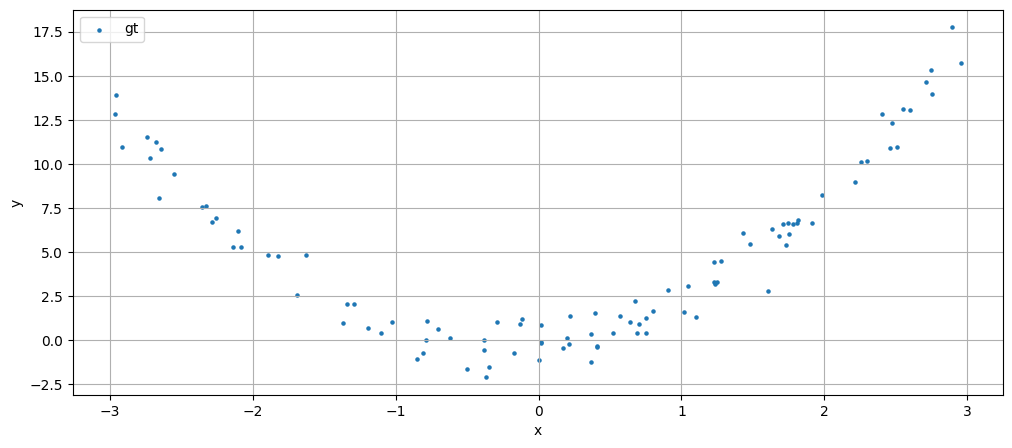

In [153]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 100

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [154]:
def model(x, a, b, c):
    return a * x ** 2 + b * x + c

In [155]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

Создадим переменные `xs_device` и `ys_device`, которые будут содержать обучающие данные сразу на нужном девайсе в виде тензоров.

**Вопрос:** `requires_grad=True` или `requires_grad=False`?

In [156]:
# YOUR CODE HERE
xs_device = torch.tensor(xs, device=device, requires_grad=False)
ys_device = torch.tensor(ys, device=device, requires_grad=False)
# END OF YOUR CODE

Теперь инициализируем веса `a`, `b` и `c` нормальным распределением:

In [157]:
# YOUR CODE HERE
a = torch.randn(1, device=device, requires_grad=True)
b = torch.randn(1, device=device, requires_grad=True)
c = torch.randn(1, device=device, requires_grad=True)
# END OF YOUR CODE

Допишем рутину обучения, чтобы получить значения весов модели.

In [158]:
num_epochs = 300
lr = 1e-4
indices = np.arange(len(xs))

loss_list, a_list, b_list, c_list = [], [], [], []

for epoch in tqdm.trange(num_epochs):
    np.random.shuffle(indices)

    loss_epoch = []
    for i in indices:
        # YOUR CODE HERE
        x      = xs_device[i]
        y_true = ys_device[i]
        y_pred = model(x,a,b,c)
        loss = (y_true - y_pred)**2
        loss.backward()
        # END OF YOUR CODE
        
        with torch.no_grad():
            #a.data -= lr * a.grad.data
            #b.data -= lr * b.grad.data
            #c.data -= lr * c.grad.data
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            a.grad.zero_()
            b.grad.zero_()
            c.grad.zero_()
            
        loss_epoch.append(loss.item())
        
    loss_list.append(np.mean(loss_epoch))
    a_list.append(a.item())
    b_list.append(b.item())
    c_list.append(c.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.31it/s]


А теперь посмотрим на результаты:

In [159]:
xs_sorted = np.sort(xs)

ys_pred_per_epoch = []
for epoch in range(num_epochs):
    a_epoch = a_list[epoch]
    b_epoch = b_list[epoch]
    c_epoch = c_list[epoch]
    with torch.no_grad():
        ys_pred_epoch = model(xs_sorted, a_epoch, b_epoch, c_epoch)
    ys_pred_per_epoch.append(ys_pred_epoch)

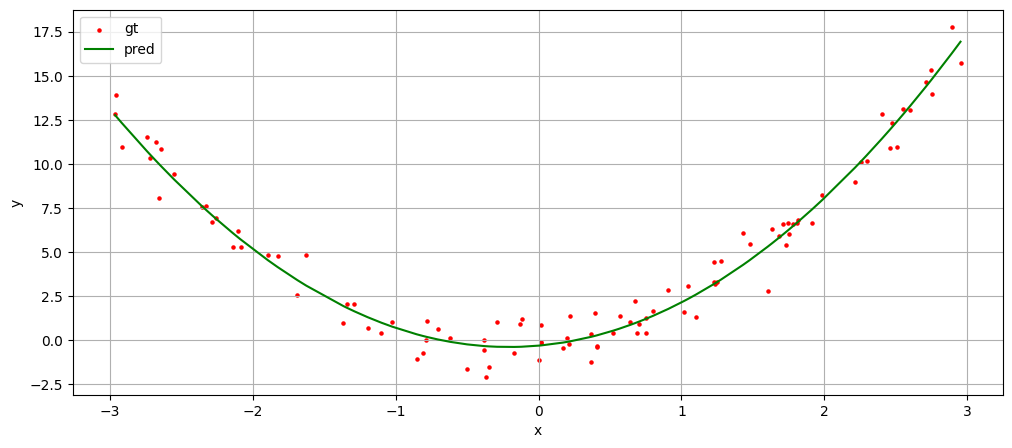

In [160]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5, c="r")
plt.plot(xs_sorted, ys_pred_per_epoch[-1], label="pred", c="g")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

Если есть нужные зависимости у `jupyterlab` (**осторожно, может все сломать**), можно сделать интерактивно:

In [161]:
#!pip install ipympl

interactive(children=(IntSlider(value=0, description='i', max=299), Output()), _dom_classes=('widget-interact'…

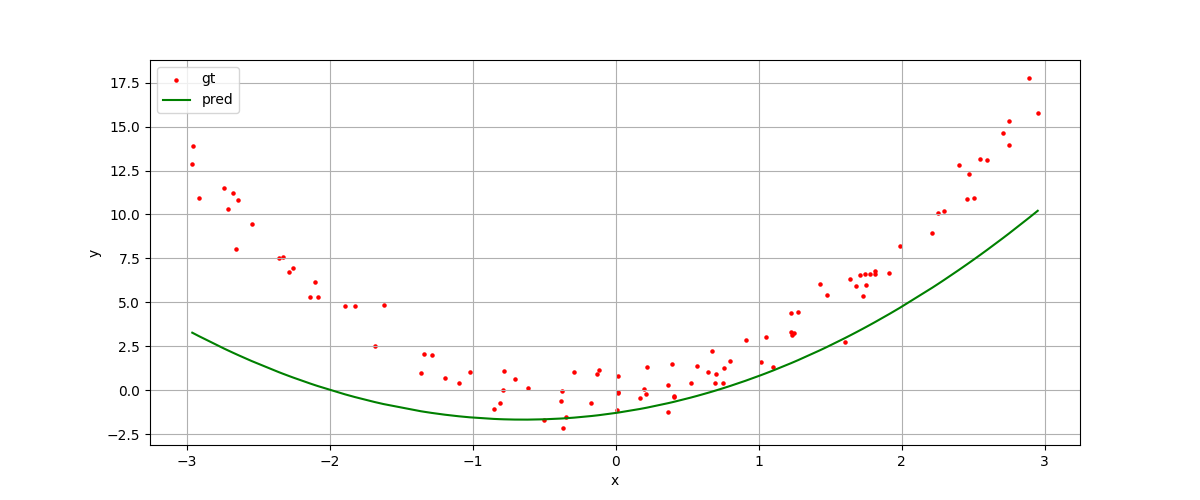

In [162]:
%matplotlib ipympl
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = xs_sorted

def f(x, i):
    return model(x, a_list[i], b_list[i], c_list[i])

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(xs, ys, label="gt", s=5, c="r")
line, = ax.plot(x, f(x, i), label="pred", c="g")

ax.legend()
ax.grid(True)


def update(i=0):
    line.set_ydata(f(x, i))
    fig.canvas.draw_idle()
    
interact(update, i=(0,num_epochs-1,1));

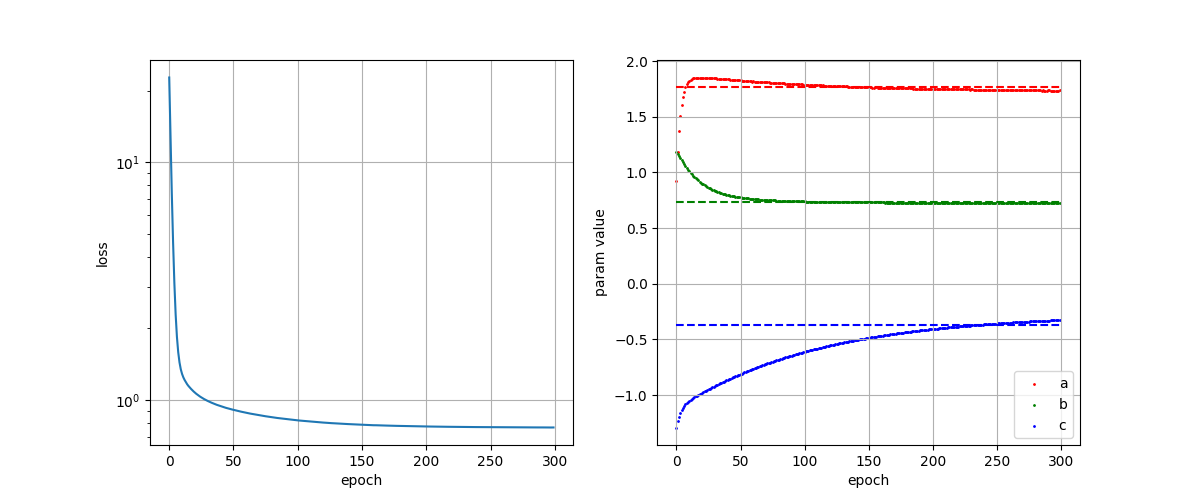

In [163]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.yscale("log")

plt.subplot(1, 2, 2)
for p_name, p_gt, p_list, color in zip(("a", "b", "c"), (_a, _b, _c), (a_list, b_list, c_list), ("r", "g", "b")):
    plt.hlines(y=p_gt, xmin=0, xmax=num_epochs, linestyles="dashed", colors=color)
    plt.scatter(range(len(p_list)), p_list, label=p_name, s=1, c=color)
plt.xlabel("epoch")
plt.ylabel("param value")
plt.legend()
plt.grid(True)

plt.show()

**Вопрос:** если бы это была "настоящая" задача, что следовало бы изменить в данном пайплайне?

## 4. Переопределение `backward`

Что, если нам хочется релизовать кстомный градиент для произвольной функции. 

Зачем?

 - Мы можем знать лучший способ посчитать градиент, чем делать бэкпроп для суперпозиции элементарных функций
 - Можем реализовать численно более устойчивый метод
 - Можем использовать функции из внешних библиотек
 - Использовать недифференцируемые функции?..

Рассмотрим сигмоиду:

$$ 
  \sigma(x) = \frac{1}{1+e^{-x}}
$$

Если честно распишем суперпозицию функций, то получим:

$$
  \sigma(x) = f_1 \odot f_2  \odot f_3 \odot f_4(x), where 
$$

$$
f_1 = \frac{1}{u}, f_2 = 1 + u, f_3 = \exp(u), f_4 = -u
$$

Тогда:

$$
\frac{\partial \sigma}{\partial x} = \frac{\partial \sigma}{\partial f_2}\frac{\partial f_2}{\partial f_3}
\frac{\partial f_3}{\partial f_4}
\frac{\partial f_4}{\partial x}
$$

Но зная как устроена производная можно упростить:

$$
\frac{\partial \sigma}{\partial x} = \sigma(x)(1 - \sigma(x))
$$

Вручную задать градиени функции в библиотеке PyTorch можно создав дочерний класс от [`torch.autograd.Function`](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd).

**NB**: Для того, чтобы сделать `backward()`, требуется знать результат `forward()`. Для этого у переменной контекста есть метод [`save_for_backward()`](https://pytorch.org/docs/stable/generated/torch.autograd.function.FunctionCtx.save_for_backward.html).

In [164]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # YOUR CODE HERE
        val = 1./(1. + torch.exp(-x))
        ctx.save_for_backward(val)
        # END OF YOUR CODE
        return val
    
    @staticmethod
    def backward(ctx, grad_output):
        # YOUR CODE HERE
        val, = ctx.saved_tensors
        grad = val*(1 - val)*grad_output
        # END OF YOUR CODE
        return grad

In [165]:
from torch.autograd import gradcheck

In [166]:
sigmoid = MySigmoid.apply
x = torch.rand(2, requires_grad=True)
print(gradcheck(sigmoid, x, eps=1e-4, atol=1e-3))

# be sure to use double for better approximation
x = torch.rand(2, requires_grad=True).double()
print(gradcheck(sigmoid, x, eps=1e-6, atol=1e-4))

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/torch/autograd/gradcheck.py:920: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


True
True


PyTorch умеет считать матрицу Якоби или матрицу Гессе для заданной функции.

In [167]:
from torch.autograd.functional import hessian, jacobian

In [168]:
jacobian(sigmoid, x)

tensor([[0.2324, 0.0000],
        [0.0000, 0.2321]], dtype=torch.float64)

In [169]:
def sum_sigmoid(x):
    return torch.sum(sigmoid(x))

In [170]:
hessian(sum_sigmoid, x)

tensor([[-0.0616,  0.0000],
        [ 0.0000, -0.0621]], dtype=torch.float64)

## Итоги

* Узнали, что такое `pytorch` и как в нем работать с тензорами
* Немного погрели GPU, запустив вычисления на нем
* Решили пример задачи, используя только библиотеку `pytorch`
* Написали собственную реализацию сигмоидальной нелинейности

Что еще почитать:
* [A gentle introduction to `torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
* [Extending pytorch](https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd)

В следующий раз: 
* (наконец-то) нейросети на pytorch

In [171]:
import torch
import torch.nn as nn

class CustomSigmoidFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Save the input for the backward pass
        ctx.save_for_backward(x)
        # Compute the sigmoid output
        output = 1 / (1 + torch.exp(-x))
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve the input saved in the forward pass
        x, = ctx.saved_tensors
        # Compute the sigmoid output again
        sigmoid_x = 1 / (1 + torch.exp(-x))
        # Compute the gradient of the sigmoid function
        grad_input = grad_output * sigmoid_x * (1 - sigmoid_x)
        return grad_input

class CustomSigmoid(nn.Module):
    def __init__(self):
        super(CustomSigmoid, self).__init__()

    def forward(self, x):
        return CustomSigmoidFunction.apply(x)

# Example usage
if __name__ == "__main__":
    model = CustomSigmoid()
    input_tensor = torch.tensor([0.0, 2.0, -2.0], requires_grad=True)
    output_tensor = model(input_tensor)
    print(f"Output: {output_tensor}")

    # Perform a backward pass
    output_tensor.sum().backward()
    print(f"Gradients: {input_tensor.grad}")

Output: tensor([0.5000, 0.8808, 0.1192], grad_fn=<CustomSigmoidFunctionBackward>)
Gradients: tensor([0.2500, 0.1050, 0.1050])
